In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from tomopt.muon import *
from tomopt.inference import *
from tomopt.loss import *
from tomopt.volume import *
from tomopt.core import *
from tomopt.optimisation import *

import matplotlib.pyplot as plt
import seaborn as sns
from typing import *
import numpy as np

import torch
from torch import Tensor, nn
import torch.nn.functional as F

# Basics

In [3]:
def arb_rad_length(*,z:float, lw:Tensor, size:float) -> float:
    rad_length = torch.ones(list((lw/size).long()))*X0['beryllium']
    if z >= 0.4 and z <= 0.5: rad_length[5:,5:] = X0['lead']
    return rad_length

In [4]:
def eff_cost(x:Tensor) -> Tensor:
    return torch.expm1(3*F.relu(x))

In [5]:
def res_cost(x:Tensor) -> Tensor:
    return F.relu(x/100)**2

In [6]:
def get_layers():
    layers = []
    lwh = Tensor([1,1,1])
    size = 0.1
    init_eff = 0.5
    init_res = 1000
    pos = 'above'
    for z,d in zip(np.arange(lwh[2],0,-size), [1,1,0,0,0,0,0,0,1,1]):
        if d:
            layers.append(DetectorLayer(pos=pos, init_eff=init_eff, init_res=init_res,
                                        lw=lwh[:2], z=z, size=size, eff_cost_func=eff_cost, res_cost_func=res_cost))
        else:
            pos = 'below'
            layers.append(PassiveLayer(rad_length_func=arb_rad_length, lw=lwh[:2], z=z, size=size))

    return nn.ModuleList(layers) 

In [7]:
volume = Volume(get_layers())

# VolumeWrapper

In [8]:
from functools import partial

In [9]:
volume = Volume(get_layers())

In [10]:
wrapper = VolumeWrapper(volume=volume, res_opt=partial(torch.optim.SGD, lr=2e1), eff_opt=partial(torch.optim.SGD, lr=2e-5), loss_func=DetectorLoss(0.025))

In [11]:
from fastprogress.fastprogress import IN_NOTEBOOK
import math

from tomopt.optimisation.callbacks.callback import Callback

r'''
This MetricLogger is a modified version of the MetricLogger in LUMIN (https://github.com/GilesStrong/lumin/blob/v0.7.2/lumin/nn/callbacks/monitors.py#L125), distributed under the following lincence:
    Copyright 2018 onwards Giles Strong

    Licensed under the Apache License, Version 2.0 (the "License");
    you may not use this file except in compliance with the License.
    You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

    Unless required by applicable law or agreed to in writing, software
    distributed under the License is distributed on an "AS IS" BASIS,
    WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
    See the License for the specific language governing permissions and
    limitations under the License.

Usage is compatible with the AGPL licence underwhich TomOpt is distributed.
Stated changes: adaption to work with `VolumeWrapper` class, replacement of the telemtry plots with task specific information.
'''
                                                               
class MetricLogger(Callback):
    r'''
    Provides live feedback during training showing a variety of metrics to help highlight problems or test hyper-parameters without completing a full training.
    If `show_plots` is false, will instead print training and validation losses at the end of each epoch.
    The full history is available as a dictionary by calling `MetricLogger.get_loss_history`.
    '''
    
    tk_sz = 16
    tk_col = 'black'
    lbl_sz = 24
    lbl_col = 'black'
    leg_sz = 16
    cat_palette = 'tab10'
    style = {'style':'whitegrid', 'rc':{'patch.edgecolor':'none'}}
    h_mid = 8
    w_mid = h_mid*16/9

    def __init__(self, show_plots:bool=IN_NOTEBOOK):
        self.show_plots = show_plots

    def on_train_begin(self) -> None:
        r'''
        Prepare for new training
        '''

        super().on_train_begin()
        self._reset()
        for c in self.wrapper.fit_params.loss_cbs: self._add_loss_name(type(c).__name__)
            
    def on_train_end(self) -> None:
        plt.clf()  # prevent plot be shown twice

    def on_epoch_begin(self) -> None:
        r'''
        Prepare to track new loss
        '''

        self.tmp_loss,self.batch_cnt,self.volume_cnt = 0,0,0
        self.tmp_sub_losses = DefaultDict(float)
        
    def on_volume_end(self) -> None:
        if self.wrapper.fit_params.state == 'valid' and self.wrapper.loss_func is not None and hasattr(self.wrapper.loss_func, 'sub_losses'):
             for k,v in self.wrapper.loss_func.sub_losses.items():
                    self.tmp_sub_losses[k] += v.data.item()
        self.volume_cnt += 1
        
    def on_backwards_end(self) -> None:
        if self.wrapper.fit_params.state == 'train':
            self.loss_vals[0].append(self.wrapper.fit_params.mean_loss.data.item())
        
    def on_volume_batch_end(self) -> None:
        if self.wrapper.fit_params.state == 'valid':
            self.tmp_loss += self.wrapper.fit_params.mean_loss.data.item()
            self.batch_cnt += 1

    def on_epoch_end(self) -> None:
        r'''
        If validation epoch finished, record validation losses, compute info and update plots
        '''

        if self.wrapper.fit_params.state == 'valid':
            self.epochs.append(self.epochs[-1]+1)
            self.loss_vals[1].append(self.tmp_loss/self.batch_cnt)
            for k,v in self.tmp_sub_losses.items():
                self.sub_losses[k].append(v/(self.loss_vals[1][-1]*self.volume_cnt))  # Fractional components
            
            for i,c in enumerate(self.wrapper.fit_params.loss_cbs): self.loss_vals[i+2].append(c.get_loss())
            for i,c in enumerate(self.metric_cbs): self.metric_vals[i].append(c.get_metric())
            if self.show_plots:
                for i, v in enumerate(self.loss_vals[1:]):
                    if self.loss_vals[i+1][-1] <= self.best_loss: self.best_loss = self.loss_vals[i+1][-1]
                self.update_plot()
            else:
                self.print_losses()

            ls = np.array(self.loss_vals[1:])[:,-1]
            m = None
            if self.lock_to_metric:
                m = self.metric_vals[self.main_metric_idx][-1]
                if not self.metric_cbs[self.main_metric_idx].lower_metric_better: m *= -1
            self.val_epoch_results = ls,m

    def _add_loss_name(self, name:str) -> None:
        self.tmp_loss_names.append(name)
        self.loss_vals.append([0 for _ in self.loss_vals[1]])

    def print_losses(self) -> None:
        r'''
        Print training and validation losses for the last epoch
        '''

        p = f'Epoch {len(self.loss_vals[1])}: Training = {np.mean(self.loss_vals[0][-self.n_trn_batches:]):.2E}'
        for v,m in zip(self.loss_vals[1:],self.tmp_loss_names[1:]): p += f' {m} = {v[-1]:.2E}'
        for m,v in zip(self.metric_cbs, self.metric_vals): p += f' {m.name} = {v[-1]:.2E}'
        print(p)

    def update_plot(self) -> None:
        r'''
        Updates the plot(s).
        '''

        # Loss
        self.loss_ax.clear()
        self.sub_loss_ax.clear()
        with sns.axes_style(**self.style), sns.color_palette(self.cat_palette):
            self.loss_ax.plot((1/self.n_trn_batches)+np.linspace(0,len(self.loss_vals[1]), self.n_trn_batches*len(self.loss_vals[1]), endpoint=False), self.loss_vals[0], label=self.tmp_loss_names[0])
            x = range(1, len(self.loss_vals[1])+1)
            for v,m in zip(self.loss_vals[1:],self.tmp_loss_names[1:]):
                self.loss_ax.plot(x, v, label=m)
            keys = sorted([k for k in self.sub_losses])
            self.sub_loss_ax.stackplot(x, *[self.sub_losses[k] for k in keys], labels=keys)
            self.loss_ax.plot([1/self.n_trn_batches,x[-1]], [self.best_loss,self.best_loss], label=f'Best = {self.best_loss:.3E}', linestyle='--')
            self.loss_ax.legend(loc='upper right', fontsize=0.8*self.leg_sz)
            self.sub_loss_ax.legend(loc='upper left', fontsize=0.8*self.leg_sz)
            for ax in [self.loss_ax, self.sub_loss_ax]:
                ax.grid(True, which="both")
                ax.set_xlim(1/self.n_trn_batches, x[-1])
            self.sub_loss_ax.set_xlabel('Epoch', fontsize=0.8*self.lbl_sz, color=self.lbl_col)
            self.loss_ax.set_ylabel('Loss', fontsize=0.8*self.lbl_sz, color=self.lbl_col)
            self.sub_loss_ax.set_ylabel('Loss Composition', fontsize=0.8*self.lbl_sz, color=self.lbl_col)
        with sns.axes_style(**self.style):
            dets = self.wrapper.get_detectors()
            res = np.array([l.resolution.data.cpu().numpy() for l in dets])
            eff = np.array([l.efficiency.data.cpu().numpy() for l in dets])
            res_min,res_max = res.min(),res.max()
            eff_min,eff_max = eff.min(),eff.max()

            for i,l in enumerate(dets):
                self.res_axes[i].clear()
                self.eff_axes[i].clear()
                sns.heatmap(res[i], ax=self.res_axes[i], cmap='viridis', square=True, cbar=(i == 0), vmin=res_min, vmax=res_max, cbar_ax=self.res_cbar_ax if i == 0 else None)
                sns.heatmap(eff[i], ax=self.eff_axes[i], cmap='plasma', square=True, cbar=(i == 0), vmin=eff_min, vmax=eff_max, cbar_ax=self.eff_cbar_ax if i == 0 else None)    
                self.eff_axes[i].set_xlabel(f'Det. {i}', fontsize=0.8*self.lbl_sz, color=self.lbl_col)
            self.res_axes[0].set_ylabel('Resolution', fontsize=0.8*self.lbl_sz, color=self.lbl_col)
            self.eff_axes[0].set_ylabel('Efficiency', fontsize=0.8*self.lbl_sz, color=self.lbl_col)
                
        if len(self.loss_vals[1]) > 1:
            # Metrics
            if self.main_metric_idx is not None:
                self.metric_ax.clear()
                with sns.axes_style(**self.style), sns.color_palette(self.cat_palette) as palette:
                    x = range(self.n_trn_batches, self.n_trn_batches*len(self.loss_vals[1])+1, self.n_trn_batches)
                    y = self.metric_vals[self.main_metric_idx]
                    self.metric_ax.plot(x, y, color=palette[1])
                    best = np.nanmin(y) if self.metric_cbs[self.main_metric_idx].lower_metric_better else np.nanmax(y)
                    self.metric_ax.plot([1,x[-1]], [best,best], label=f'Best = {best:.3E}', linestyle='--', color=palette[2])
                    self.metric_ax.legend(loc='upper left', fontsize=0.8*self.leg_sz)
                    self.metric_ax.grid(True, which="both")
                    self.metric_ax.set_xlim(1/self.n_trn_batches, x[-1])
                    self.metric_ax.set_xlabel('Epoch', fontsize=0.8*self.lbl_sz, color=self.lbl_col)
                    self.metric_ax.set_ylabel(self.metric_cbs[self.main_metric_idx].name, fontsize=0.8*self.lbl_sz, color=self.lbl_col)
            self.display.update(self.fig)
        else:
            self.display.update(self.loss_ax.figure)
            
    @staticmethod
    def _sort_cbs(cbs:List[Callback]) -> List[Callback]:
        metric_cbs = []
        for c in cbs:
            if hasattr(c, 'get_metric'):
                metric_cbs.append(c)
        return metric_cbs

    def _reset(self) -> None:
        self.tmp_loss_names = ['Training', 'Validation']
        self.loss_vals = [[] for _ in self.tmp_loss_names]
        self.sub_losses = DefaultDict(list)
        self.best_loss,self.epochs = math.inf,[0]
        self.n_trn_batches = len(self.wrapper.fit_params.trn_passives) // self.wrapper.fit_params.passive_bs
        
        self.metric_cbs = self._sort_cbs(self.wrapper.fit_params.cbs)
        self.metric_vals = [[] for _ in self.metric_cbs]
        self.main_metric_idx = None
        self.lock_to_metric = False
        if len(self.metric_cbs) > 0:
            self.main_metric_idx = 0
            for i,c in enumerate(self.metric_cbs):
                if c.main_metric:
                    self.main_metric_idx = i
                    self.lock_to_metric = True
                    break

        if self.show_plots:
            with sns.axes_style(**self.style):
                self.fig = plt.figure(figsize=(self.w_mid, self.w_mid), constrained_layout=True)
                self.n_dets = len(self.wrapper.get_detectors())
                gs = self.fig.add_gridspec(5+(self.main_metric_idx is None), self.n_dets)
                self.loss_ax = self.fig.add_subplot(gs[:3,:])
                self.sub_loss_ax = self.fig.add_subplot(gs[3:4,:])
                if self.main_metric_idx is not None:
                    self.metric_ax = self.fig.add_subplot(gs[4:5,:])
                for ax in [self.loss_ax, self.sub_loss_ax]:
                    ax.tick_params(axis='x', labelsize=0.8*self.tk_sz, labelcolor=self.tk_col)
                    ax.tick_params(axis='y', labelsize=0.8*self.tk_sz, labelcolor=self.tk_col)
                self.sub_loss_ax.set_xlabel('Epoch', fontsize=0.8*self.lbl_sz, color=self.lbl_col)
                self.loss_ax.set_ylabel('Loss', fontsize=0.8*self.lbl_sz, color=self.lbl_col)
                self.sub_loss_ax.set_ylabel('Loss Composition', fontsize=0.8*self.lbl_sz, color=self.lbl_col)
                if self.main_metric_idx is not None:
                    self.metric_ax.tick_params(axis='x', labelsize=0.8*self.tk_sz, labelcolor=self.tk_col)
                    self.metric_ax.tick_params(axis='y', labelsize=0.8*self.tk_sz, labelcolor=self.tk_col)
                    self.metric_ax.set_xlabel('Epoch', fontsize=0.8*self.lbl_sz, color=self.lbl_col)
                    self.metric_ax.set_ylabel(self.metric_cbs[self.main_metric_idx].name, fontsize=0.8*self.lbl_sz, color=self.lbl_col)
                self.res_axes = [self.fig.add_subplot(gs[-2:-1,i:i+1]) for i in range(self.n_dets)]
                self.eff_axes = [self.fig.add_subplot(gs[-1:,  i:i+1]) for i in range(self.n_dets)]
                self.res_cbar_ax = self.fig.add_axes([1.0, 0.04, .03, 0.31])
                self.eff_cbar_ax = self.fig.add_axes([1.1, 0.04, .03, 0.31])
                for i in range(self.n_dets):
                    self.eff_axes[i].set_xlabel(f'Det. {i}', fontsize=0.8*self.lbl_sz, color=self.lbl_col)
                self.res_axes[0].set_ylabel('Resolution', fontsize=0.8*self.lbl_sz, color=self.lbl_col)
                self.eff_axes[0].set_ylabel('Efficiency', fontsize=0.8*self.lbl_sz, color=self.lbl_col)
                self.display = display(self.fig, display_id=True)
                
    def get_loss_history(self) -> Tuple[OrderedDict,OrderedDict]:
        r'''
        Get the current history of losses and metrics

        Returns:
            history: tuple of ordered dictionaries: first with losses, second with validation metrics
        '''

        history = (OrderedDict(),OrderedDict())
        for v,m in zip(self.loss_vals,self.tmp_loss_names): history[0][m] = v
        for v,c in zip(self.metric_vals,self.metric_cbs): history[1][c.name] = v
        return history

    def get_results(self, save_best:bool) -> Dict[str,float]:
        r'''
        Returns losses and metrics of the (loaded) wrapper

        #TODO: extend this to load at specified index

        Arguments:
            save_best: if the training used :class:`~lumin.nn.callbacks.monitors.SaveBest` return results at best point else return the latest values

        Returns:
            dictionary of validation loss and metrics
        '''

        losses = np.array(self.loss_vals[1:])
        metrics = np.array(self.metric_vals)
        results = {}
        
        if save_best:
            if self.main_metric_idx is None or not self.lock_to_metric or len(losses) > 1:  # Tracking SWA only supported for loss
                idx = np.unravel_index(np.nanargmin(losses), losses.shape)[-1]
                results['loss'] = np.nanmin(losses)
            else:
                idx = np.nanargmin(self.metric_vals[self.main_metric_idx]) if self.metric_cbs[self.main_metric_idx].lower_metric_better else \
                    np.nanargmax(self.metric_vals[self.main_metric_idx])
                results['loss'] = losses[0][idx]
        else:
            results['loss'] = np.nanmin(losses[:,-1:])
            idx = -1
        if len(self.metric_cbs) > 0:
            for c,v in zip(self.metric_cbs,metrics[:,idx]): results[c.name] = v
        return results


In [12]:
from tomopt.optimisation import MetricLogger

In [13]:
ml = MetricLogger()

In [14]:
trn_passives = PassiveYielder([arb_rad_length,arb_rad_length])

In [16]:
%%time
_ = wrapper.fit(10, n_mu_per_volume=1000, mu_bs=100, passive_bs=1, trn_passives=trn_passives, val_passives=trn_passives, cbs=[NoMoreNaNs()])

CPU times: user 1min 57s, sys: 19.1 s, total: 2min 16s
Wall time: 1min 59s


%%time
_ = wrapper.fit(10, n_mu_per_volume=1000, mu_bs=100, passive_bs=1, trn_passives=trn_passives, val_passives=trn_passives, cbs=[NoMoreNaNs(),ml])

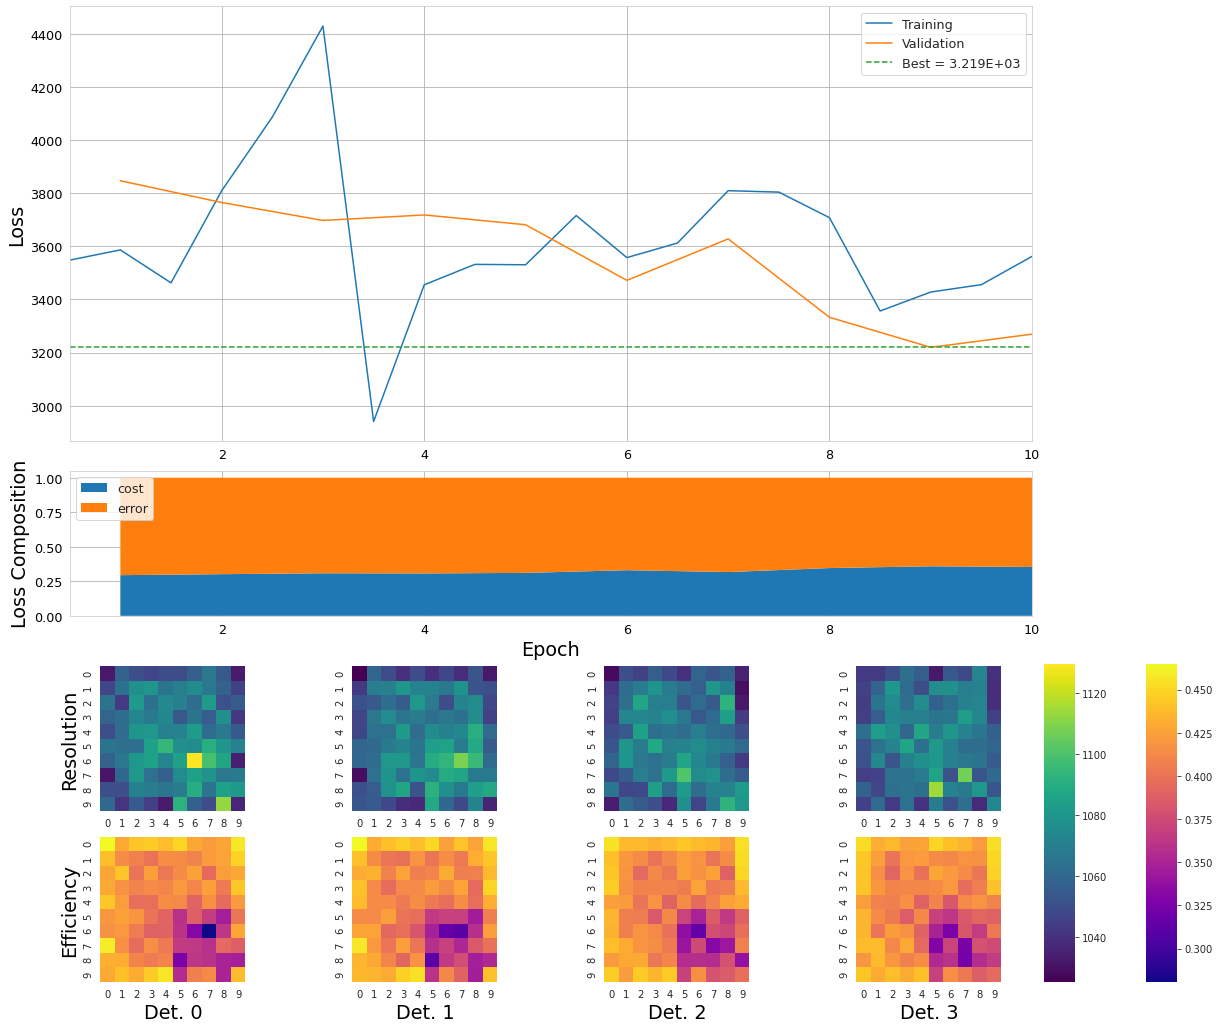

CPU times: user 2min 54s, sys: 21.4 s, total: 3min 16s
Wall time: 2min 56s


<Figure size 1024x1024 with 0 Axes>

In [41]:
%%time
_ = wrapper.fit(10, n_mu_per_volume=1000, mu_bs=100, passive_bs=1, trn_passives=trn_passives, val_passives=trn_passives, cbs=[NoMoreNaNs(),ml])

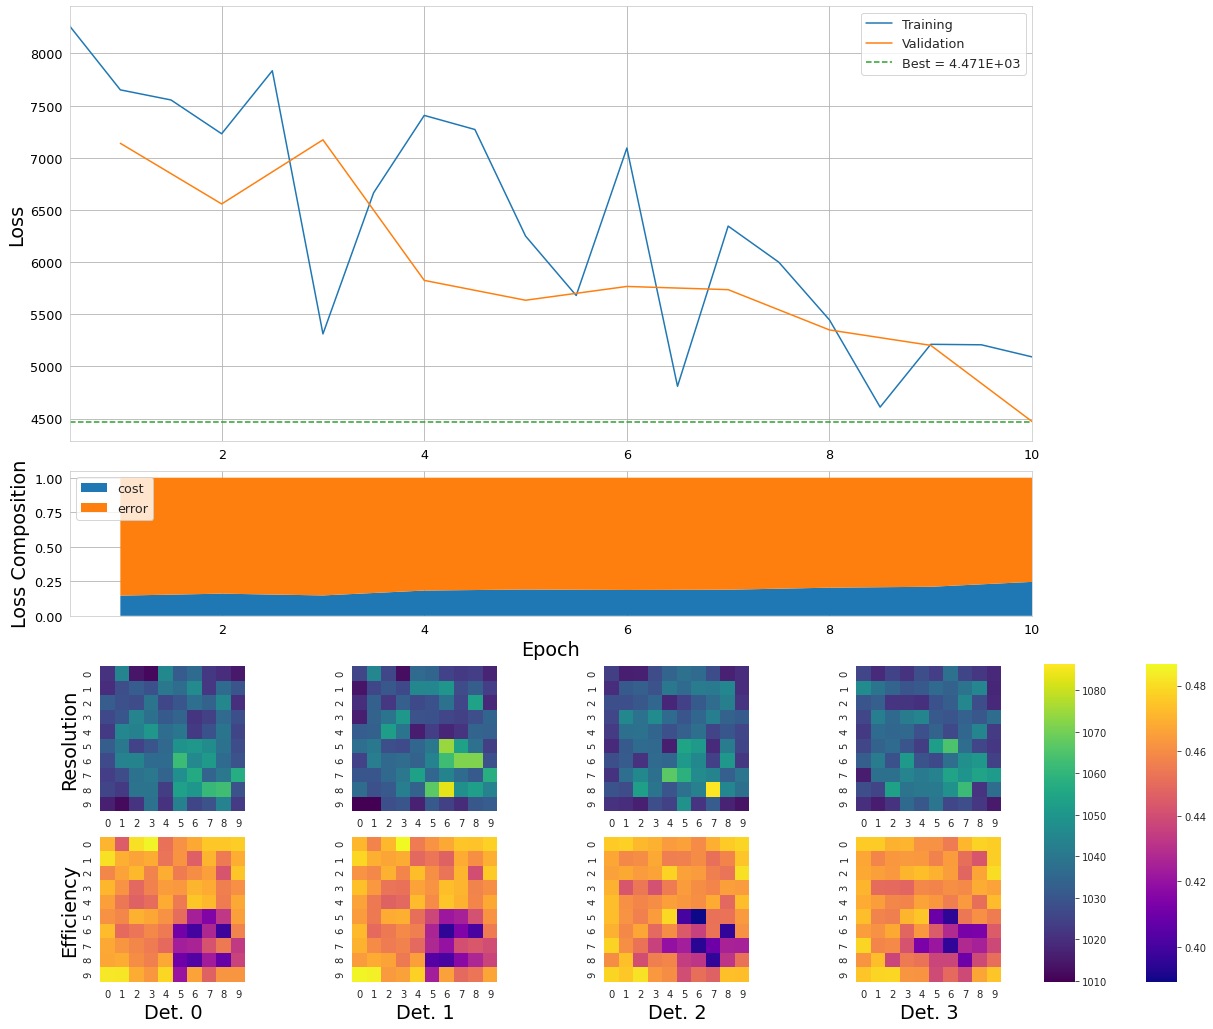

CPU times: user 2min 57s, sys: 21.3 s, total: 3min 19s
Wall time: 3min


<Figure size 1024x1024 with 0 Axes>

In [15]:
%%time
_ = wrapper.fit(10, n_mu_per_volume=1000, mu_bs=100, passive_bs=1, trn_passives=trn_passives, val_passives=trn_passives, cbs=[NoMoreNaNs(),ml])